# Gene expression signatures

How to get gene matrix?

Use the following bash in ``My-RNASeq-Pipeline``
```bash
for i in `seq 0 9`; do echo $i; Rscript ./scripts/expression_summary/summarize_expression_kallisto.2.R ./NAVY_CHARM_20200816/kallisto/summary/all_sample.v2.part_$i.txt ./scripts/sleuth/t2g_hg38.txt NAVY_CHARM_20200816/kallisto/summary/TPM_matrix.part_$i hg38 ; done

Rscript ./scripts/expression_summary/summarize_expression_kallisto.2.R ./DUKE_WHOLE_BLOOD_20200612/kallisto/summary/all_sample.txt ./scripts/sleuth/t2g_hg38.txt DUKE_WHOLE_BLOOD_20200612/kallisto/summary/TPM_matrix hg38
```

In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2022-05-28 15:51:12.932835
Simons Foundation, Rusty HPC, worker2015


In [2]:
%cd ..
%load_ext rpy2.ipython

/mnt/ceph/users/zzhang/CHARM-AlternativeSplicing


## 1. Read in data

In [3]:
# import everything we will need from jemm
from jemm.junction import JunctionCountTable
from jemm.transcript import TranscriptMeasureTable
from jemm.model import Jemm, JemmLinearRegression
from jemm.plots import facet_boxplot, beta_barplot
from jemm.covariate import Contrasts, Covariate

from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score, roc_auc_score

import scipy.stats as ss
import pickle
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm

from jemm.meta_loader import MetaLoader
from jemm.covariate import Contrasts, Covariate

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'ieee'])
import scipy

DATA_VER = 'data-V7'
PCS_TO_INCL = '0,6'
USE_RE = True

CLFDIR = '%s/deg_classifier' % DATA_VER
os.makedirs(CLFDIR, exist_ok=True)

%run ./notebooks/navy_utils.V7.py $DATA_VER $PCS_TO_INCL $USE_RE

Cannot find mygene package, GeneSet functionality will be limited; you can install it by `pip install mygene`
navy_utils.py data-V7 ['PC0', 'PC6'] True


In [4]:
df1 = pd.read_table("./%s/CHARM.TPM_matrix.geneSymbol.txt"%CLFDIR, index_col=0)


In [5]:
df1 = df1[[x for x in df1.columns if x in covs.meta.index]]
df1 = df1[~df1.index.duplicated(keep='first')]

In [6]:
duke_folder = 'duke_whole_blood'

duke_contrasts = Contrasts(name="Pathogen", levels=[
    'healthy', 
    'COVID-19'
])
duke_covs_wb = Covariate(fp="./data-V7/%s/meta_full.tsv" %duke_folder, sep="\t", 
                 index_col=0,
                 contrasts=duke_contrasts,
                 main_effects=['Pathogen', 'gender', 'days_since_onset'],
                 verbose=True
             )
df2 = pd.read_table("./%s/DUKE.TPM_matrix.geneSymbol.txt"%CLFDIR, index_col=0)
df2 = df2[~df2.index.duplicated(keep='first')]
common_genes = set([g for g in df2.index if g in df1.index])
df1 = df1.loc[common_genes]
df2 = df2.loc[common_genes]

print(df1.shape)
print(df2.shape)

(51825, 1176)
(51825, 66)


/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


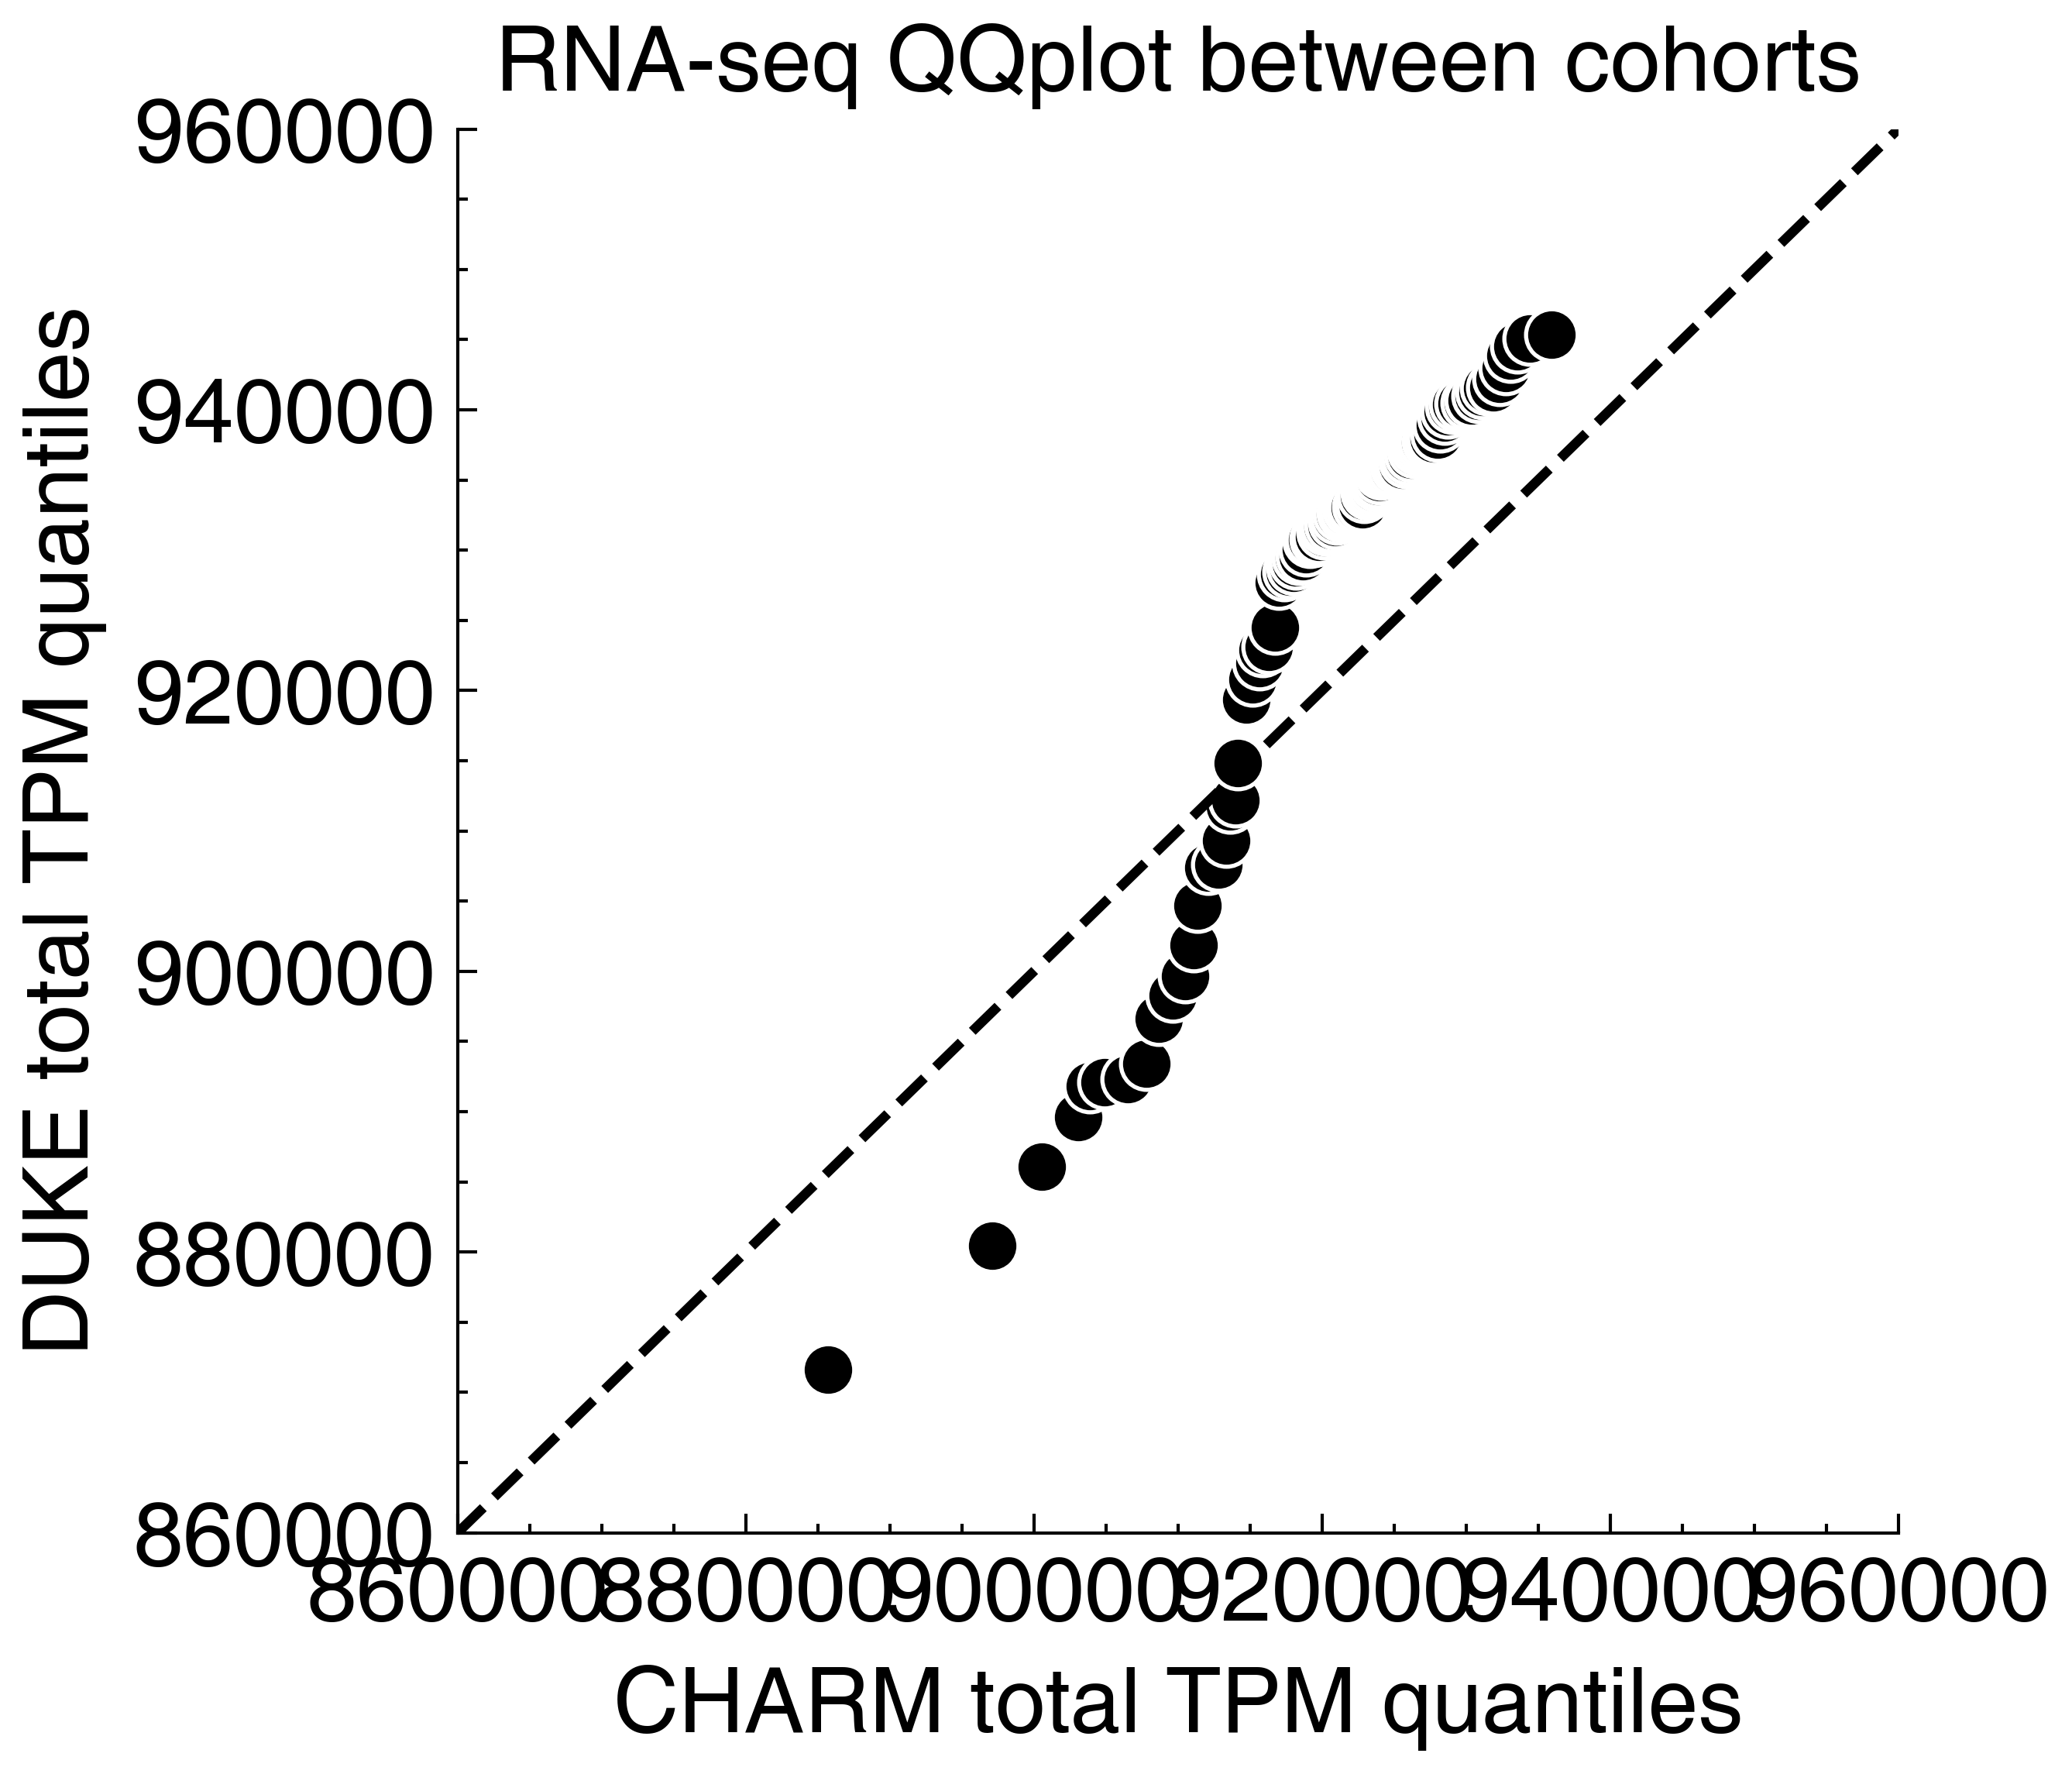

In [7]:
ax = sns.scatterplot(
    np.percentile(df1.sum(axis=0), np.arange(1,99,1)),
    np.percentile(df2.sum(axis=0), np.arange(1,99,1)),
)
ax.set_title("RNA-seq QQplot between cohorts")
ax.set_xlabel('CHARM total TPM quantiles')
ax.set_ylabel('DUKE total TPM quantiles')
ax.set_xlim(8.6*10**5, 9.6*10**5)
ax.set_ylim(8.6*10**5, 9.6*10**5)

ax.plot([0,1],[0,1], transform=ax.transAxes, ls='--', color='black')

In [8]:
def get_expr_df(tot_gids, df, dropnan=True):
    expr_df = df.loc[tot_gids]
    expr_df = expr_df.transpose()
    if dropnan is True:
        expr_df = expr_df.dropna(axis=1)    
    return expr_df

## 2. Define the CHARM samples

In [9]:
# get total pre samples with RNA-seq (in sample index)
total_pre = covs.meta.loc[covs.meta.final=='Pre']
total_pre=set(list([x for x in df1.columns if x in total_pre.index]))
pre_subject_ids = list(set([x.split('-')[0] for x in total_pre]))
pre_subject_samps = list(set([(y, covs.meta.loc[y, 'final'], covs.meta.loc[y, 'Sex']) for x in pre_subject_ids
                     for y in df1.columns if y.split('-')[0] == x]))

# up to here is a list of (sid, final), where the individual is Pre at one tp
pre_df = pd.DataFrame(pre_subject_samps, columns=['ID', 'final', 'Sex'])

# adding a preceding P is necessary as to not confuse seaborn..
pre_df['individual'] = ["P"+x.split('-')[0] for x in pre_df['ID']]
pre_df['tp'] = [int(x.split('-')[1].lstrip('T')) for x in pre_df['ID']]
pre_df.index = pre_df['ID']
print(pre_df.shape)

# this is a df of controls that with Pre
pre_df.head()

(235, 5)


,ID,final,Sex,individual,tp
ID,,,,,
20_0170-T46,20_0170-T46,Mid,M,P20_0170,46
20_0170-T53,20_0170-T53,Mid,M,P20_0170,53
20_1273-T17,20_1273-T17,Mid,M,P20_1273,17
20_2219-T14,20_2219-T14,Mid,M,P20_2219,14
20_2219-T17,20_2219-T17,Mid,M,P20_2219,17


In [10]:
# get total first/first-mid/mid samples with RNA-seq (in sample index)
total_infect = covs.meta.loc[covs.meta.final.isin(['Control','Pre', 'First', 'Mid'])]

# get the ones with RNA-seq
total_infect = [x for x in df1.columns if x in total_infect.index]

# strip the subject ids
inft_subject_ids = list(set([x.split('-')[0] for x in total_infect]))

# dummy join
inft_subject_samps = [(y, covs.meta.loc[y, 'final'], covs.meta.loc[y, 'Sex']) for x in inft_subject_ids
                     for y in df1.columns \
                     if y.split('-')[0] == x and y.split('-')[0]]

# up to here is a list of (sid, final), where the individual is Pre at one tp
inft_df = pd.DataFrame(inft_subject_samps, columns=['ID', 'final', 'Sex'])
inft_df.drop_duplicates(inplace=True)

# adding a preceding P is necessary as to not confuse seaborn..
inft_df['individual'] = ["P"+x.split('-')[0] for x in inft_df['ID']]
inft_df['tp'] = [int(x.split('-')[1].lstrip('T')) for x in inft_df['ID']]
inft_df.index = inft_df['ID']
inft_df = inft_df.loc[inft_df.final.isin(['Control','First', 'Mid'])]
print(inft_df.shape)
inft_df['final'].unique()

(532, 5)


array(['Control', 'Mid', 'First'], dtype=object)

In [11]:
# Do not include Pre, and Controls related to Pre
infect_train_df = inft_df.loc[~inft_df['ID'].isin(pre_df.loc[pre_df['final'].isin(['Control', 'Pre'])]['ID'])]


# 4. Get DEGs by statistical tests

In [12]:
ctrl_sids = covs.meta.query("final=='Control'")
first_sids = covs.meta.query("final=='First'")
res_df = {'gene':[], 'ctrl_mean':[], 'first_mean':[], 'log2fc':[], 'mw_pval':[], 't_pval':[]}
for _, gene_row in tqdm(df1.iterrows(), total=df1.shape[0]):
    try:
        mw = ss.mannwhitneyu(gene_row[ctrl_sids.index], gene_row[first_sids.index]).pvalue
    except ValueError:
        mw = 1
    t = ss.ttest_ind(gene_row[ctrl_sids.index], gene_row[first_sids.index]).pvalue
    res_df['gene'].append(gene_row.name)
    res_df['ctrl_mean'].append(gene_row[ctrl_sids.index].mean())
    res_df['first_mean'].append(gene_row[first_sids.index].mean())
    res_df['log2fc'].append( np.abs(np.log2(res_df['ctrl_mean'][-1]+1) - np.log2(res_df['first_mean'][-1]+1)) )    
    res_df['mw_pval'].append(mw)
    res_df['t_pval'].append(t)



100%|██████████| 51825/51825 [02:12<00:00, 391.10it/s]


In [13]:
from jemm.utils import fdr_bh

deg_df = pd.DataFrame(res_df)
deg_df['mw_fdr'] = fdr_bh(deg_df['mw_pval'])
deg_df['t_fdr'] = fdr_bh(deg_df['t_pval'])
deg_df['mw_bonf'] = deg_df['mw_pval']*deg_df.shape[0]
deg_df['t_bonf'] = deg_df['t_pval']*deg_df.shape[0]
deg_df.index = deg_df['gene']

In [14]:
# Discovery and validation of a three-gene signature to distinguish COVID-19 and other viral infections in emergency infectious disease presentations: a case-control and observational cohort study
#https://www.thelancet.com/journals/lanmic/article/PIIS2666-5247(21)00145-2/fulltext
#HERC6, IGF1R, and NAGK

gene_sig1 = ['HERC6', 'IGF1R', 'NAGK']

In [15]:
# A blood RNA transcriptome signature for COVID-19
# https://bmcmedgenomics.biomedcentral.com/articles/10.1186/s12920-021-01006-w#MOESM1
# Supplementary Table 3. List of the 135 protein-coding-gene COVID-19 signature from the comparison between COVID-19 cases and controls (false discovery rate < 0.05; log2 fold change > 1 or < -1).
gene_sig2 = """
Ensembl_ID	Genename	Gene description	log2FC	logCPM
ENSG00000091262	ABCC6	ATP binding cassette subfamily C member 6 	-1	6.7
ENSG00000159618	ADGRG5	adhesion G protein-coupled receptor G5 	-1.3	6.4
ENSG00000148926	ADM	adrenomedullin 	1.1	5.1
ENSG00000188157	AGRN	agrin 	2.1	4.9
ENSG00000140379	BCL2A1	BCL2 related protein A1 	1.4	3.7
ENSG00000106605	BLVRA	biliverdin reductase A 	1.2	3.7
ENSG00000130303	BST2	bone marrow stromal cell antigen 2 	1.5	6.7
ENSG00000166323	C11orf65	chromosome 11 open reading frame 65 	-1.1	8.1
ENSG00000122783	C7orf49	cell cycle regulator of NHEJ 	1	10.6
ENSG00000165181	C9orf84	shortage in chiasmata 1 	-1.4	5
ENSG00000141837	CACNA1A	calcium voltage-gated channel subunit alpha1 A 	1.1	4.3
ENSG00000163823	CCR1	C-C motif chemokine receptor 1 	1.3	5.3
ENSG00000183625	CCR3	C-C motif chemokine receptor 3 	1	10.2
ENSG00000134058	CDK7	cyclin dependent kinase 7 	-1.4	3.6
ENSG00000124762	CDKN1A	cyclin dependent kinase inhibitor 1A 	1.3	4.6
ENSG00000086065	CHMP5	charged multivesicular body protein 5 	1	3.8
ENSG00000137200	CMTR1	cap methyltransferase 1 	1.1	5.3
ENSG00000203667	COX20	cytochrome c oxidase assembly factor COX20 	-1.1	5.3
ENSG00000104218	CSPP1	centrosome and spindle pole associated protein 1 	-1.1	3.3
ENSG00000229754	CXCR2P1	C-X-C motif chemokine receptor 2 pseudogene 1 	1.6	4.3
ENSG00000073737	DHRS9	dehydrogenase/reductase 9 	1.9	3
ENSG00000108771	DHX58	DExH-box helicase 58 	1.8	5.6
ENSG00000175550	DRAP1	DR1 associated protein 1 	1	7.4
ENSG00000146425	DYNLT1	dynein light chain Tctex-type 1 	1.1	4.4
ENSG00000172889	EGFL7	EGF like domain multiple 7 	1.5	2.6
ENSG00000055332	EIF2AK2	eukaryotic translation initiation factor 2 alpha kinase 2 	1	3.5
ENSG00000132464	ENAM	enamelin 	1.3	9.8
ENSG00000132199	ENOSF1	enolase superfamily member 1 	1.3	5.3
ENSG00000133106	EPSTI1	epithelial stromal interaction 1 	2.6	5.7
ENSG00000149564	ESAM	endothelial cell adhesion molecule 	1	3.6
ENSG00000116663	FBXO6	F-box protein 6 	1.4	4.5
ENSG00000150337	FCGR1A	Fc fragment of IgG receptor Ia 	1.3	4.5
ENSG00000126262	FFAR2	free fatty acid receptor 2 	1.2	7.3
ENSG00000134183	GNAT2	G protein subunit alpha transducin 2 	-1	5.7
ENSG00000189060	H1F0	H1.0 linker histone 	1.1	5.1
ENSG00000130589	HELZ2	helicase with zinc finger 2 	1.3	8.3
ENSG00000138642	HERC6	HECT and RLD domain containing E3 ubiquitin protein ligase family member 6 	1.2	5.1
ENSG00000010704	HFE	homeostatic iron regulator 	1.3	4.4
ENSG00000216331	HIST1H1PS1	H1.12 linker histone, cluster member pseudogene 	1.5	4.4
ENSG00000180573	HIST1H2AC	H2A clustered histone 6 	1.1	6.5
ENSG00000180596	HIST1H2BC	H2B clustered histone 4 	1	3
ENSG00000158373	HIST1H2BD	H2B clustered histone 5 	1.1	4.5
ENSG00000124635	HIST1H2BJ	H2B clustered histone 11 	1.2	2.5
ENSG00000278828	HIST1H3H	H3 clustered histone 10 	1.1	3.8
ENSG00000184678	HIST2H2BE	H2B clustered histone 21 	1	4.6
ENSG00000068079	IFI35	interferon induced protein 35 	1.9	6.1
ENSG00000126709	IFI6	interferon alpha inducible protein 6 	2.7	8.1
ENSG00000185745	IFIT1	interferon induced protein with tetratricopeptide repeats 1 	2.7	5.8
ENSG00000119922	IFIT2	interferon induced protein with tetratricopeptide repeats 2 	1.9	6.2
ENSG00000119917	IFIT3	interferon induced protein with tetratricopeptide repeats 3 	2.7	6.7
ENSG00000152778	IFIT5	interferon induced protein with tetratricopeptide repeats 5 	1.8	4.7
ENSG00000142089	IFITM3	interferon induced transmembrane protein 3 	2.1	9.1
ENSG00000211895	IGHA1	immunoglobulin heavy constant alpha 1 	1.7	8.8
ENSG00000211890	IGHA2	immunoglobulin heavy constant alpha 2 (A2m marker) 	1.1	6.5
ENSG00000211896	IGHG1	immunoglobulin heavy constant gamma 1 (G1m marker) 	2	8.6
ENSG00000211893	IGHG2	immunoglobulin heavy constant gamma 2 (G2m marker) 	1.3	7
ENSG00000211897	IGHG3	immunoglobulin heavy constant gamma 3 (G3m marker) 	1.6	6
ENSG00000239951	IGKV3-20	immunoglobulin kappa variable 3-20 	1.3	5.1
ENSG00000211677	IGLC2	immunoglobulin lambda constant 2 	1.7	7.4
ENSG00000211679	IGLC3	immunoglobulin lambda constant 3 (Kern-Oz+ marker) 	1.2	5.9
ENSG00000211666	IGLV2-14	immunoglobulin lambda variable 2-14 	1.2	3.8
ENSG00000136689	IL1RN	interleukin 1 receptor antagonist 	2	5.6
ENSG00000185507	IRF7	interferon regulatory factor 7 	2.2	8.2
ENSG00000187608	ISG15	ISG15 ubiquitin like modifier 	3.8	9.3
ENSG00000173801	JUP	junction plakoglobin 	2.1	5.7
ENSG00000144445	KANSL1L	KAT8 regulatory NSL complex subunit 1 like 	-1	4.8
ENSG00000108773	KAT2A	lysine acetyltransferase 2A 	1.1	4.2
ENSG00000185909	KLHDC8B	kelch domain containing 8B 	1.4	3.4
ENSG00000089692	LAG3	lymphocyte activating 3 	1.5	3.1
ENSG00000002549	LAP3	leucine aminopeptidase 3 	1.6	4.8
ENSG00000148346	LCN2	lipocalin 2 	2.1	4.2
ENSG00000108679	LGALS3BP	galectin 3 binding protein 	2.3	5.7
ENSG00000168961	LGALS9	galectin 9 	1.2	6.5
ENSG00000187116	LILRA5	leukocyte immunoglobulin like receptor A5 	1.1	4
ENSG00000186818	LILRB4	leukocyte immunoglobulin like receptor B4 	1.1	4.6
ENSG00000107798	LIPA	lipase A, lysosomal acid type 	2.2	12.4
ENSG00000238083	LRRC37A2	leucine rich repeat containing 37 member A2 	-1.1	5
ENSG00000160932	LY6E	lymphocyte antigen 6 family member E 	3.1	9
ENSG00000204103	MAFB	MAF bZIP transcription factor B 	1.1	5.8
ENSG00000183019	MCEMP1	mast cell expressed membrane protein 1 	1	2.8
ENSG00000104738	MCM4	minichromosome maintenance complex component 4 	1	2.3
ENSG00000100985	MMP9	matrix metallopeptidase 9 	1.2	6.8
ENSG00000155363	MOV10	Mov10 RISC complex RNA helicase 	1.4	5.5
ENSG00000125148	MT2A	metallothionein 2A 	2.9	6.2
ENSG00000157601	MX1	MX dynamin like GTPase 1 	2.4	8.3
ENSG00000183486	MX2	MX dynamin like GTPase 2 	1.3	7.3
ENSG00000170476	MZB1	marginal zone B and B1 cell specific protein 	1.6	4.1
ENSG00000130202	NECTIN2	nectin cell adhesion molecule 2 	1.5	3.6
ENSG00000165030	NFIL3	nuclear factor, interleukin 3 regulated 	1.1	3.8
ENSG00000196358	NTNG2	netrin G2 	1.3	6.7
ENSG00000089127	OAS1	2'-5'-oligoadenylate synthetase 1 	3	7
ENSG00000111335	OAS2	2'-5'-oligoadenylate synthetase 2 	2.6	6.5
ENSG00000111331	OAS3	2'-5'-oligoadenylate synthetase 3 	2.9	7.9
ENSG00000135114	OASL	2'-5'-oligoadenylate synthetase like 	3.1	6.5
ENSG00000177989	ODF3B	outer dense fiber of sperm tails 3B 	1.2	6.7
ENSG00000059378	PARP12	poly(ADP-ribose) polymerase family member 12 	1.4	5.8
ENSG00000138496	PARP9	poly(ADP-ribose) polymerase family member 9 	1.1	5.6
ENSG00000145287	PLAC8	placenta associated 8 	1.1	5.1
ENSG00000188313	PLSCR1	phospholipid scramblase 1 	1.9	4.3
ENSG00000140464	PML	promyelocytic leukemia 	1.3	6.7
ENSG00000197549	PRAMENP	PRAME N-terminal like, pseudogene 	1.1	6
ENSG00000100567	PSMA3	proteasome 20S subunit alpha 3 	-1.1	4.9
ENSG00000119707	RBM25	RNA binding motif protein 25 	-1.1	4
ENSG00000169385	RNASE2	ribonuclease A family member 2 	1.4	3
ENSG00000234719	RP11-166B2.1	nuclear pore complex interacting protein family member B2 	1.1	4.8
ENSG00000279296	RP11-609D21.3	p53 regulation associated lncRNA 	1.2	8
ENSG00000250349	RP5-972B16.2	novel proline rich Gla (G-carboxyglutamic acid) 1 (PRRG1) and tetraspanin 7 (TSPAN7) protein	-1.2	5.7
ENSG00000188282	RUFY4	RUN and FYVE domain containing 4 	1.6	7.9
ENSG00000163220	S100A9	S100 calcium binding protein A9 	1	12.1
ENSG00000130066	SAT1	spermidine/spermine N1-acetyltransferase 1 	1.1	7.1
ENSG00000130489	SCO2	cytochrome c oxidase assembly protein	1.3	6.5
ENSG00000149131	SERPING1	serpin family G member 1 	3.1	5.6
ENSG00000149212	SESN3	sestrin 3 	-1	3.7
ENSG00000164054	SHISA5	shisa family member 5 	1.3	8.1
ENSG00000088827	SIGLEC1	sialic acid binding Ig like lectin 1 	3.8	7.1
ENSG00000004939	SLC4A1	solute carrier family 4 member 1 (Diego blood group) 	-1.1	5.8
ENSG00000183023	SLC8A1	solute carrier family 8 member A1 	-1	4.7
ENSG00000214872	SMTNL1	smoothelin like 1 	2.4	7.7
ENSG00000185482	STAC3	SH3 and cysteine rich domain 3 	1.1	2.8
ENSG00000134809	TIMM10	translocase of inner mitochondrial membrane 10 	1.1	3
ENSG00000121858	TNFSF10	TNF superfamily member 10 	1.3	5
ENSG00000135148	TRAFD1	TRAF-type zinc finger domain containing 1 	1.1	5.8
ENSG00000132274	TRIM22	tripartite motif containing 22 	1.3	6.3
ENSG00000132256	TRIM5	tripartite motif containing 5 	1.1	10.9
ENSG00000185880	TRIM69	tripartite motif containing 69 	1.1	4.2
ENSG00000123297	TSFM	Ts translation elongation factor, mitochondrial 	-1.1	5.2
ENSG00000140830	TXNL4B	thioredoxin like 4B 	1.1	6.8
ENSG00000025708	TYMP	thymidine phosphorylase 	1.1	8.4
ENSG00000156587	UBE2L6	ubiquitin conjugating enzyme E2 L6 	1.5	6.6
ENSG00000168899	VAMP5	vesicle associated membrane protein 5 	1.1	4.7
ENSG00000132530	XAF1	XIAP associated factor 1 	1.5	4.6
ENSG00000124256	ZBP1	Z-DNA binding protein 1 	2	6.3
ENSG00000141664	ZCCHC2	zinc finger CCHC-type containing 2 	1	4.8
ENSG00000162714	ZNF496	zinc finger protein 496 	1	4
ENSG00000196357	ZNF565	zinc finger protein 565 	-1	5.6"""

gene_sig2 = [x.split("\t")[1] for x in gene_sig2.split("\n")[2::] if len(x)]
gene_sig2 = [g for g in gene_sig2 if g in df1.index]
print(len(gene_sig2))

129


## 4. Build Classifier and Cross-cohort Duke data prediction

In [16]:
# load and match DAS
(clfs, das_model_eval_df, train_stats, train_psi_dfs, train_dfs, duke_psi_dfs, duke_preds, duke_y) = pickle.load(
    open('%s/das_classifier/predictive_model_dict.pkl' % DATA_VER, 'rb'))


/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [17]:
das_model_eval_df

,No. Exons,Test AUPR,Test AUROC,PSI model,FDR cutoff
FirstExon0.001-FirstSamps,363,0.901688,0.839866,mixed,0.001
FirstExon0.01-FirstSamps,574,0.911160,0.815230,mixed,0.01
FirstExon0.05-FirstSamps,908,0.817352,0.697648,mixed,0.05
FirstExon0.001-FirstSamps-LM,322,0.882660,0.797312,linear,0.001
FirstExon0.01-FirstSamps-LM,513,0.878452,0.774916,linear,0.01
FirstExon0.05-FirstSamps-LM,848,0.823570,0.670773,linear,0.05


In [18]:
configs = {
    'Lancet': {
        'feature_gids': gene_sig1,
        'train_conds': "final=='Control' or final=='First'",
    },

    'BMC': {
        'feature_gids': gene_sig2,
        'train_conds': "final=='Control' or final=='First'",
    },
    
    # Mann-Whitney results are sub-par to T-tests
    #'CHARM-MW-twofold': {
    #    'feature_gids': deg_df.query('mw_fdr<0.001 and log2fc>1').index,
    #    'train_conds': "final=='Control' or final=='First'",
    #},
    #'CHARM-MW-top100': {
    #    'feature_gids': deg_df.sort_values('mw_fdr').head(100).index,
    #    'train_conds': "final=='Control' or final=='First'",
    #},
    #'CHARM-MW-top300': {
    #    'feature_gids': deg_df.sort_values('mw_fdr').head(300).index,
    #    'train_conds': "final=='Control' or final=='First'",
    #},
    #'CHARM-MW-top500': {
    #    'feature_gids': deg_df.sort_values('mw_fdr').head(500).index,
    #    'train_conds': "final=='Control' or final=='First'",
    #},

    'CHARM-t-fc1': {
        'feature_gids': deg_df.query('t_fdr<0.001 and log2fc>1').index,
        'train_conds': "final=='Control' or final=='First'",
    },
    'CHARM-t-fc.5': {
        'feature_gids': deg_df.query('t_fdr<0.001 and log2fc>0.5').index,
        'train_conds': "final=='Control' or final=='First'",
    },

    'CHARM-t-top100': {
        'feature_gids': deg_df.sort_values('t_fdr').head(100).index,
        'train_conds': "final=='Control' or final=='First'",
    },
    'CHARM-t-top300': {
        'feature_gids': deg_df.sort_values('t_fdr').head(300).index,
        'train_conds': "final=='Control' or final=='First'",
    },
    'CHARM-t-top500': {
        'feature_gids': deg_df.sort_values('t_fdr').head(500).index,
        'train_conds': "final=='Control' or final=='First'",
    },
    'CHARM-t-top700': {
        'feature_gids': deg_df.sort_values('t_fdr').head(700).index,
        'train_conds': "final=='Control' or final=='First'",
    },
    'CHARM-t-top1000': {
        'feature_gids': deg_df.sort_values('t_fdr').head(1000).index,
        'train_conds': "final=='Control' or final=='First'",
    },

}


In [19]:
def build_classifier(feature_gids, train_conds, add_sex_term=False):
    stats = {}
    feature_df = get_expr_df(feature_gids, df=df1)
    stats['feature_expr.shape'] = feature_df.shape
    train_df = infect_train_df.query(train_conds)

    stats['train_df.shape'] = train_df.shape
    stats['feature_df.columns'] = feature_df.columns
    X_train = feature_df.loc[train_df.ID].to_numpy()
    y_train = np.array([1 if train_df['final'][i]!='Control' else 0 for i in range(train_df.shape[0])])
    if add_sex_term is True:
        X_train = np.concatenate([
            np.expand_dims(infect_train_df.query(train_conds)['Sex']=="M", -1),
            X_train
        ], axis=1)
    prop_y = np.mean(y_train)
    stats['clf.class_weight'] = (1-prop_y)/prop_y 
    clf = LogisticRegression(
        class_weight={0:1, 1: (1-prop_y)/prop_y},
        penalty='l2', 
        C=1,
        solver='liblinear', 
        max_iter=1000, 
        random_state=777
    )
    cvx = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
    y_pred = cross_val_predict(clf, X_train, y_train, cv=cvx, method='predict_proba', n_jobs=1)
    clf.fit(X_train, y_train)
    pred_train = clf.predict_proba(X_train)[:, 1]
    #train_df['first_clf_pred'] = pred_train
    stats['clf.coef'] = pd.Series(clf.coef_[0], index=feature_df.columns if add_sex_term is False else \
                                 ['is_male'] + feature_df.columns.to_list())
    stats['y_train.cv_pred'] = y_pred
    return clf, train_df, feature_df, stats

In [20]:
# Use Duke study with whole-blood samples
duke_covs = duke_covs_wb

def build_tester(trained_clf, feature_gids, feature_df_columns, add_sex_term=False):
    stats = {}
    duke_expr_df = get_expr_df(feature_gids, df=df2, dropnan=False)
    # re-order the x matrix so it matched the beta
    duke_expr_df = duke_expr_df.loc[:, feature_df_columns]
    duke_expr_df.fillna(duke_expr_df.mean(skipna=True), inplace=True)
    duke_expr_df.fillna(0, inplace=True)
    stats['n_features'] = duke_expr_df.shape[1]
    duke_X = duke_expr_df.to_numpy()
    if add_sex_term is True:
        duke_X = np.concatenate([
            np.expand_dims(duke_covs.covariate['gender@MALE'].to_numpy(), -1),
            duke_X
        ], axis=1)
    duke_y = np.array(
        # meta.csv
        #[1 if duke_covs.meta.loc[i, 'cond'][i]=='COVID' else 0 for i in duke_metaloader.junction_measure.columns]
        # meta_full.tsv
        [1 if duke_covs.meta.loc[i, 'Pathogen']=='COVID-19' else 0 for i in df2.columns]
    )
    duke_pred = trained_clf.predict_proba(duke_X)[:,1]
    stats['test_aupr'] = average_precision_score(duke_y, duke_pred)
    stats['test_auc'] = roc_auc_score(duke_y, duke_pred)
    return duke_y, duke_pred, duke_expr_df, stats

In [21]:
reload = True
if reload is False:
    model_evals = {}
    clfs = {}
    train_dfs = {}
    duke_preds = {}
    train_stats = {}
    train_psi_dfs = {}
    duke_psi_dfs = {}
    for model_id in configs:
        print(model_id)
        clf, train_df, train_psi_df, train_stat = build_classifier(
            **configs[model_id])
        duke_y, duke_pred, duke_psi_df, test_stat = build_tester(
            trained_clf=clf,
            feature_gids=configs[model_id]['feature_gids'], 
            feature_df_columns=train_stat['feature_df.columns'],
            add_sex_term=configs[model_id].get('add_sex_term', False)
        )
        model_evals[model_id] = test_stat
        clfs[model_id] = clf
        train_dfs[model_id] = train_df
        duke_preds[model_id] = duke_pred
        train_stats[model_id] = train_stat
        train_psi_dfs[model_id] = train_psi_df
        duke_psi_dfs[model_id] = duke_psi_df

    model_eval_df = pd.DataFrame.from_dict(model_evals, orient='index')
    model_eval_df.rename(columns={
        'n_features': 'No. Genes', 
        'test_aupr': 'Test AUPR', 
        'test_auc': 'Test AUROC', 
        'feature_qval': 'FDR cutoff'}, inplace=True)
    #model_eval_df['PSI model'] = ['linear' if x.endswith('LM') else 'mixed' for x in model_eval_df.index]
    model_eval_df['FDR cutoff'] = [x.split('-')[0].lstrip('FirstExon') for x in model_eval_df.index]
    model_eval_df.to_csv("%s/performance.tsv" % CLFDIR, sep="\t", index=True)

    pickle.dump((clfs, model_eval_df, train_stats, train_psi_dfs, train_dfs, duke_psi_dfs, duke_preds, duke_y), open('%s/predictive_model_dict.pkl' % CLFDIR, 'wb'))
    
    print('trained model from scratch')
    print('saved to ' + '%s/predictive_model_dict.pkl' % CLFDIR)
    print(model_eval_df)
else:
    print('skipped training from scratch')

skipped training from scratch


In [22]:
if reload is True:
    (clfs, model_eval_df, train_stats, train_psi_dfs, train_dfs, duke_psi_dfs, duke_preds, duke_y) = pickle.load(
        open('%s/predictive_model_dict.pkl' % CLFDIR, 'rb'))
    print('reloaded previously trained model')
else:
    print('skipped reloading')
model_eval_df

reloaded previously trained model


,No. Genes,Test AUPR,Test AUROC,FDR cutoff
Lancet,3,0.755121,0.541993,Lancet
BMC,129,0.788189,0.515118,BMC
CHARM-t-fc1,407,0.856792,0.688130,CHARM
CHARM-t-fc.5,1432,0.922477,0.812990,CHARM
CHARM-t-top100,100,0.761765,0.506719,CHARM
CHARM-t-top300,300,0.900129,0.808511,CHARM
CHARM-t-top500,500,0.923639,0.837626,CHARM
CHARM-t-top700,700,0.891140,0.768197,CHARM
CHARM-t-top1000,1000,0.774394,0.526316,CHARM


/mnt/home/zzhang/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


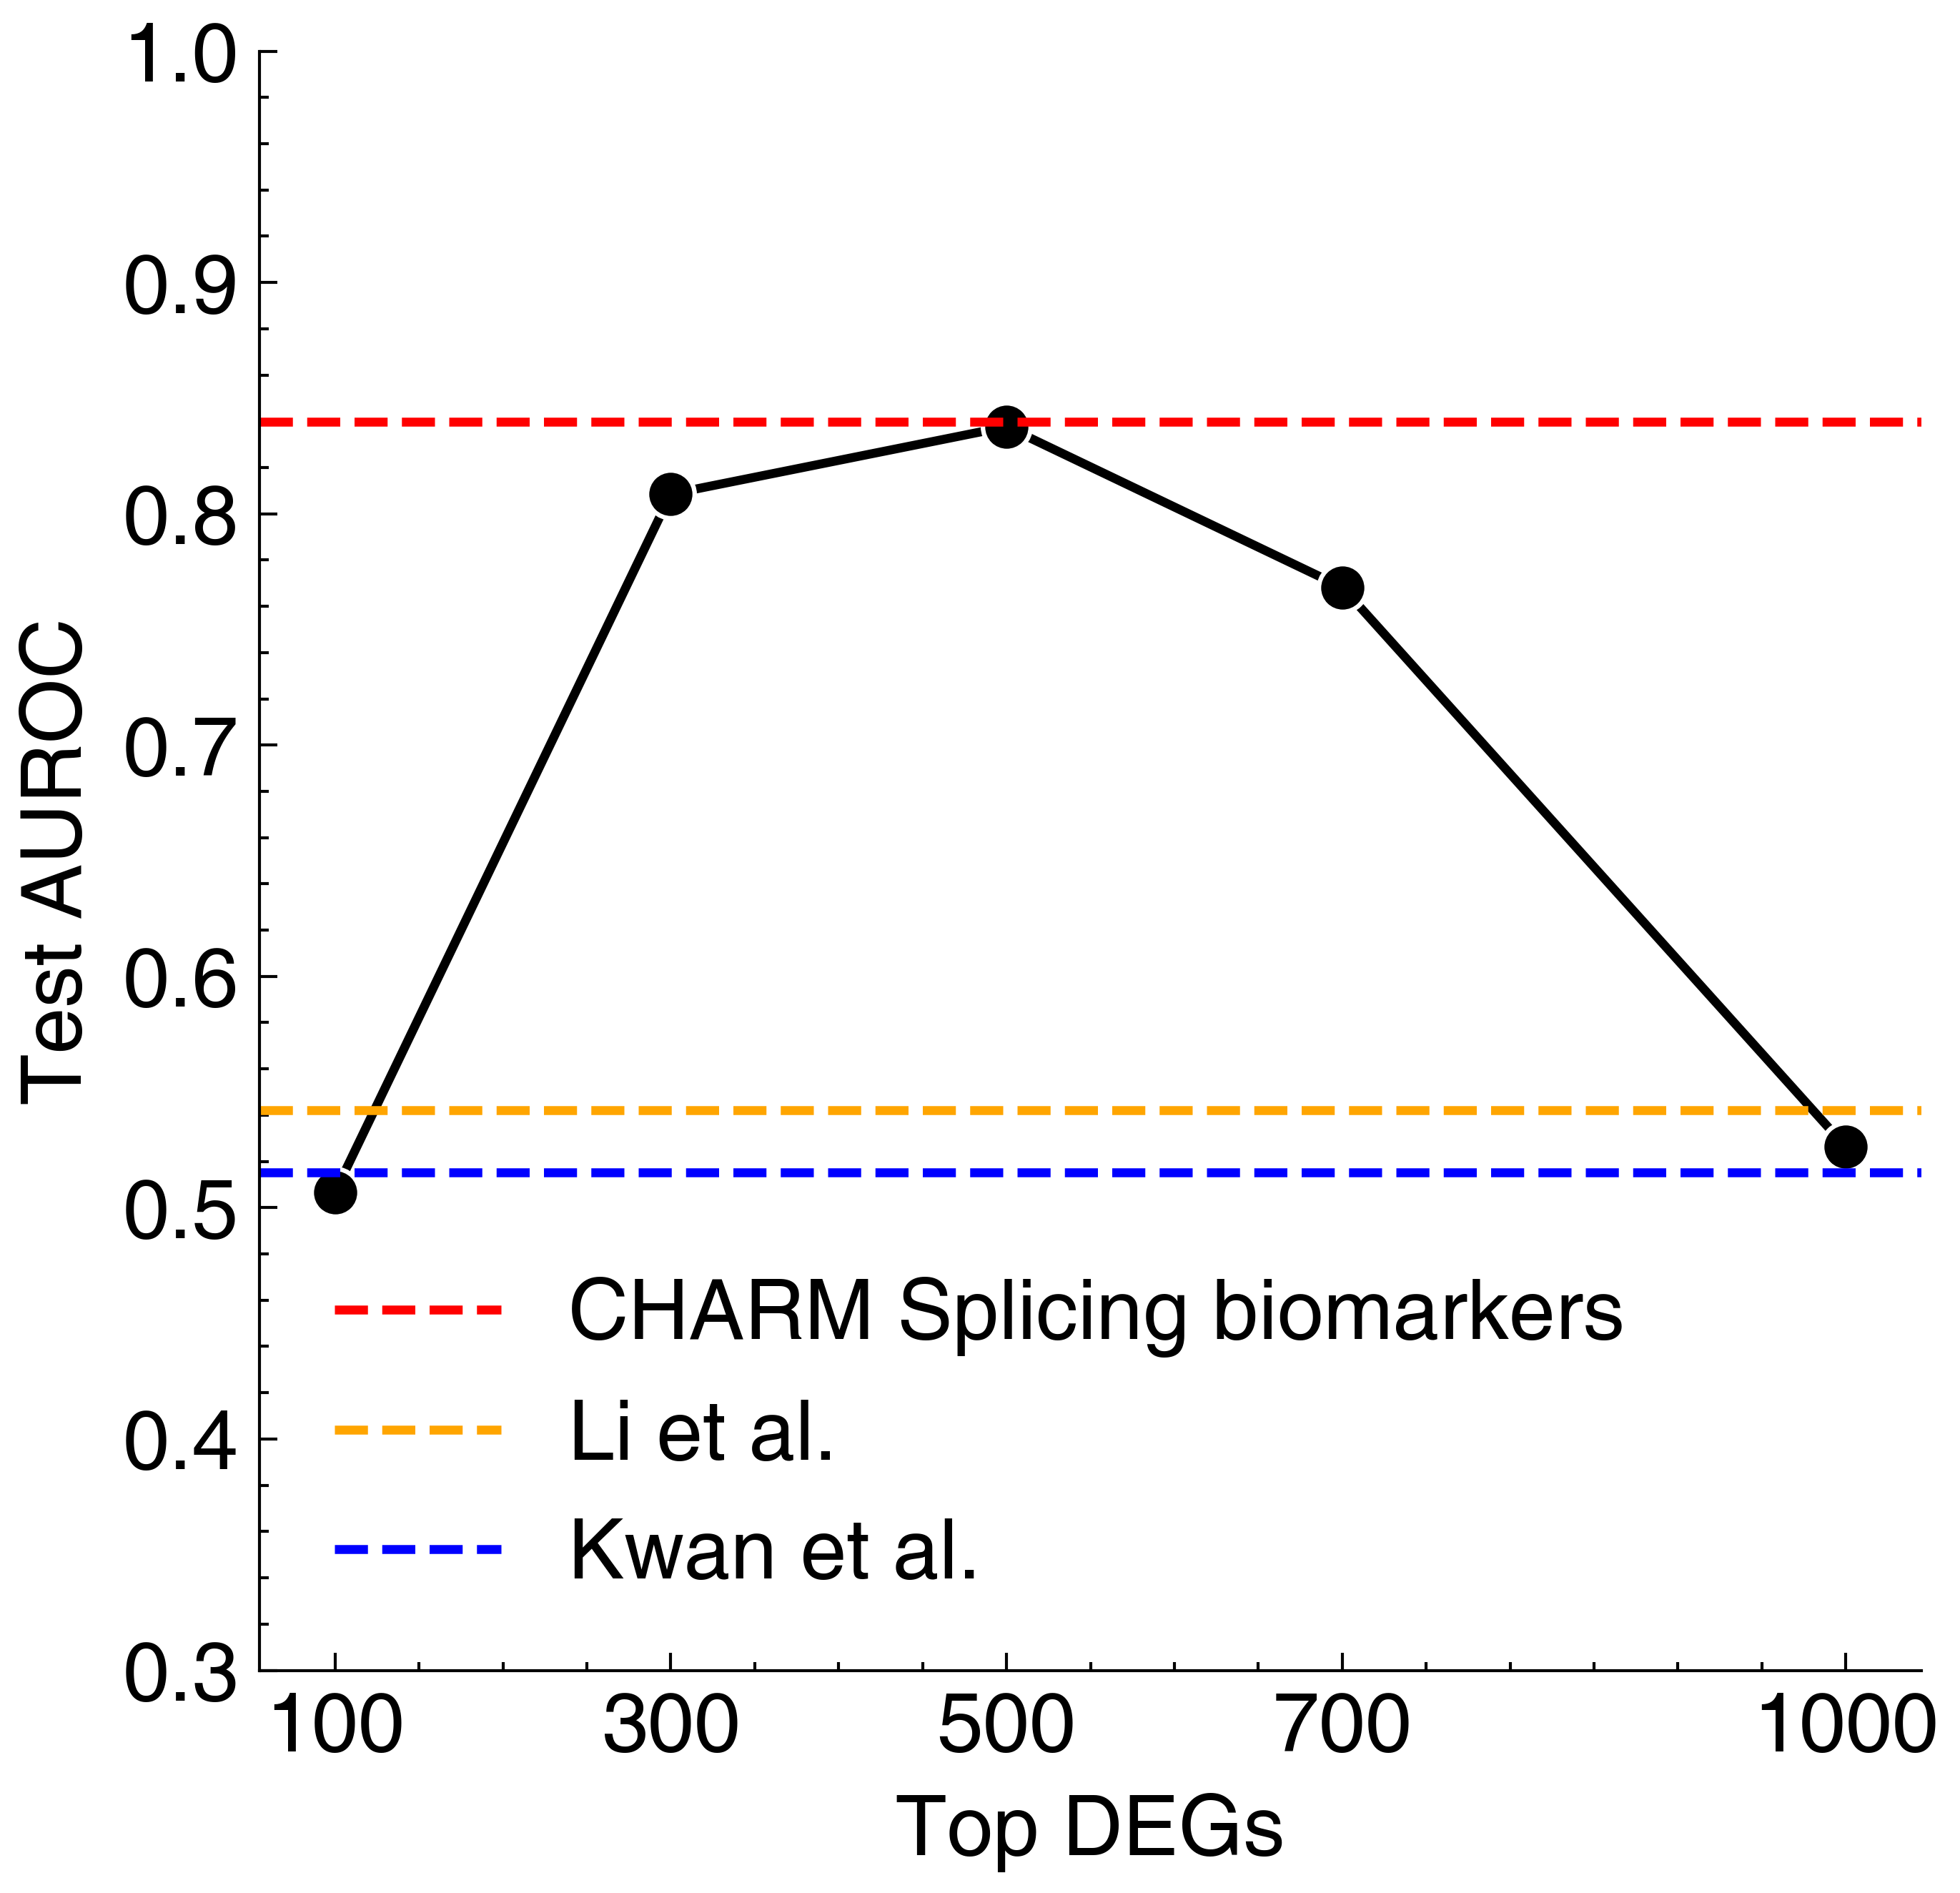

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plot_df = model_eval_df.iloc[-5:]
plot_df['Top DEGs'] = [int(x.split('-')[-1][3:]) for x in plot_df.index]
sns.lineplot(x='Top DEGs', y='Test AUROC', marker='o', ls='-', #markersize=4, 
             data=plot_df)
#ax.set_title('Duke Cohort prediction by DEG')
ax.set_ylim(0.3, 1)
ax.axhline(y=das_model_eval_df.loc['FirstExon0.001-FirstSamps', 'Test AUROC'], ls='--', color="red", label="CHARM Splicing biomarkers")
ax.axhline(y=model_eval_df.loc['Lancet', 'Test AUROC'], ls='--', color="orange", label="Li et al.")
ax.axhline(y=model_eval_df.loc['BMC', 'Test AUROC'], ls='--', color="blue", label="Kwan et al.")
ax.set_xticks([100, 300, 500, 700, 1000])
ax.legend()

fig.savefig("%s/01-performance.pdf" % CLFDIR)

In [24]:
print("FINISH:", datetime.now())

FINISH: 2022-05-28 15:53:44.017828
